# ThoughtLink — Wavelet vs Non-Wavelet Comparison

Side-by-side comparison of feature sets:
- **Standard** (66 features): Band power + Hjorth + Time domain
- **With Wavelets** (138 features): Standard + DWT wavelet features

Which models benefit from wavelets? Which don't?

In [1]:
import sys
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score, cohen_kappa_score,
    f1_score, classification_report,
)

sys.path.insert(0, str(Path('.').resolve().parent / 'src'))

from thoughtlink.data.loader import load_all, CLASS_NAMES
from thoughtlink.data.splitter import split_by_subject
from thoughtlink.preprocessing.eeg import preprocess_all
from thoughtlink.preprocessing.windowing import windows_from_samples
from thoughtlink.features.eeg_features import extract_features_from_windows
from thoughtlink.models.baseline import build_baselines
from thoughtlink.models.hierarchical import HierarchicalClassifier, RELAX_IDX

results_dir = Path('../results')
sns.set_theme(style='whitegrid', font_scale=1.1)
%matplotlib inline

## 1. Load & Preprocess (shared)

In [2]:
samples = load_all()
train_samples, test_samples = split_by_subject(samples, test_size=0.2)
preprocess_all(train_samples)
preprocess_all(test_samples)

X_train_win, y_train, _ = windows_from_samples(train_samples)
X_test_win, y_test, _ = windows_from_samples(test_samples)
print(f'Windows: {X_train_win.shape[0]} train, {X_test_win.shape[0]} test')

Fetching 903 files:   0%|          | 0/903 [00:00<?, ?it/s]

Loaded 900 samples from /Users/david.camachob/Documents/thoughtlink/notebooks/data/raw
Classes: ['Both Fists', 'Left Fist', 'Relax', 'Right Fist', 'Tongue Tapping']
Subjects: 6
Split: 5 train subjects (810 samples), 1 test subjects (90 samples)


Preprocessed 100/810 samples


Preprocessed 200/810 samples


Preprocessed 300/810 samples


Preprocessed 400/810 samples


Preprocessed 500/810 samples


Preprocessed 600/810 samples


Preprocessed 700/810 samples


Preprocessed 800/810 samples


Windows: 12150 train, 1350 test


## 2. Extract Both Feature Sets

In [3]:
# Standard features (no wavelet)
t0 = time.time()
X_train_std = extract_features_from_windows(X_train_win, include_time_domain=True, include_wavelet=False)
X_test_std = extract_features_from_windows(X_test_win, include_time_domain=True, include_wavelet=False)
t_std = time.time() - t0

# Wavelet features
t0 = time.time()
X_train_wav = extract_features_from_windows(X_train_win, include_time_domain=True, include_wavelet=True)
X_test_wav = extract_features_from_windows(X_test_win, include_time_domain=True, include_wavelet=True)
t_wav = time.time() - t0

print(f'Standard: {X_train_std.shape[1]} features ({t_std:.1f}s)')
print(f'Wavelet:  {X_train_wav.shape[1]} features ({t_wav:.1f}s)')
print(f'Added:    {X_train_wav.shape[1] - X_train_std.shape[1]} wavelet features')

Standard: 66 features (2.7s)
Wavelet:  138 features (6.7s)
Added:    72 wavelet features


## 3. Train Both Configurations

In [4]:
def train_and_collect(X_train, X_test, y_train, y_test, label):
    """Train all models, return predictions and metrics."""
    models = build_baselines()
    preds = {}
    mets = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds[name] = model.predict(X_test)
        mets[name] = {
            'acc': accuracy_score(y_test, preds[name]),
            'kappa': cohen_kappa_score(y_test, preds[name]),
            'f1': f1_score(y_test, preds[name], average='macro', zero_division=0),
        }
    
    hier = HierarchicalClassifier(stage1_threshold=0.5)
    hier.fit(X_train, y_train)
    preds['hierarchical'] = hier.predict(X_test)
    mets['hierarchical'] = {
        'acc': accuracy_score(y_test, preds['hierarchical']),
        'kappa': cohen_kappa_score(y_test, preds['hierarchical']),
        'f1': f1_score(y_test, preds['hierarchical'], average='macro', zero_division=0),
    }
    
    print(f'\n{label}:')
    for name, m in mets.items():
        print(f'  {name}: acc={m["acc"]:.3f}, kappa={m["kappa"]:.3f}, f1={m["f1"]:.3f}')
    
    return preds, mets, models, hier

print('Training Standard (66 features)...')
preds_std, mets_std, models_std, hier_std = train_and_collect(
    X_train_std, X_test_std, y_train, y_test, 'Standard (66 features)')

print('\nTraining Wavelet (138 features)...')
preds_wav, mets_wav, models_wav, hier_wav = train_and_collect(
    X_train_wav, X_test_wav, y_train, y_test, 'Wavelet (138 features)')

Training Standard (66 features)...


Stage 1: 2430 Relax, 9720 Active


Stage 2: 9720 active samples, 4 classes



Standard (66 features):
  logreg: acc=0.226, kappa=0.032, f1=0.201
  svm_linear: acc=0.250, kappa=0.062, f1=0.224
  svm_rbf: acc=0.188, kappa=-0.015, f1=0.191
  random_forest: acc=0.209, kappa=0.011, f1=0.197
  hierarchical: acc=0.202, kappa=0.003, f1=0.181

Training Wavelet (138 features)...


Stage 1: 2430 Relax, 9720 Active


Stage 2: 9720 active samples, 4 classes



Wavelet (138 features):
  logreg: acc=0.173, kappa=-0.033, f1=0.160
  svm_linear: acc=0.207, kappa=0.009, f1=0.192
  svm_rbf: acc=0.218, kappa=0.022, f1=0.185
  random_forest: acc=0.243, kappa=0.054, f1=0.232
  hierarchical: acc=0.201, kappa=0.001, f1=0.161


## 4. Comparison Table

In [5]:
rows = []
for name in mets_std:
    delta_acc = mets_wav[name]['acc'] - mets_std[name]['acc']
    delta_kappa = mets_wav[name]['kappa'] - mets_std[name]['kappa']
    rows.append({
        'Model': name,
        'Std Accuracy': mets_std[name]['acc'],
        'Wav Accuracy': mets_wav[name]['acc'],
        'Delta Acc': delta_acc,
        'Std Kappa': mets_std[name]['kappa'],
        'Wav Kappa': mets_wav[name]['kappa'],
        'Delta Kappa': delta_kappa,
        'Std F1': mets_std[name]['f1'],
        'Wav F1': mets_wav[name]['f1'],
    })

df_cmp = pd.DataFrame(rows).sort_values('Std Accuracy', ascending=False).reset_index(drop=True)

def color_delta(val):
    if val > 0.01: return 'background-color: #bbf7d0'  # green
    elif val < -0.01: return 'background-color: #fecaca'  # red
    return ''

df_cmp.style.format({
    'Std Accuracy': '{:.1%}', 'Wav Accuracy': '{:.1%}', 'Delta Acc': '{:+.1%}',
    'Std Kappa': '{:.3f}', 'Wav Kappa': '{:.3f}', 'Delta Kappa': '{:+.3f}',
    'Std F1': '{:.3f}', 'Wav F1': '{:.3f}',
}).map(color_delta, subset=['Delta Acc', 'Delta Kappa'])

,Model,Std Accuracy,Wav Accuracy,Delta Acc,Std Kappa,Wav Kappa,Delta Kappa,Std F1,Wav F1
0,svm_linear,25.0%,20.7%,-4.2%,0.062,0.009,-0.053,0.224,0.192
1,logreg,22.6%,17.3%,-5.3%,0.032,-0.033,-0.066,0.201,0.160
2,random_forest,20.9%,24.3%,+3.4%,0.011,0.054,+0.043,0.197,0.232
3,hierarchical,20.2%,20.1%,-0.1%,0.003,0.001,-0.002,0.181,0.161
4,svm_rbf,18.8%,21.8%,+3.0%,-0.015,0.022,+0.037,0.191,0.185


## 5. Side-by-Side Accuracy

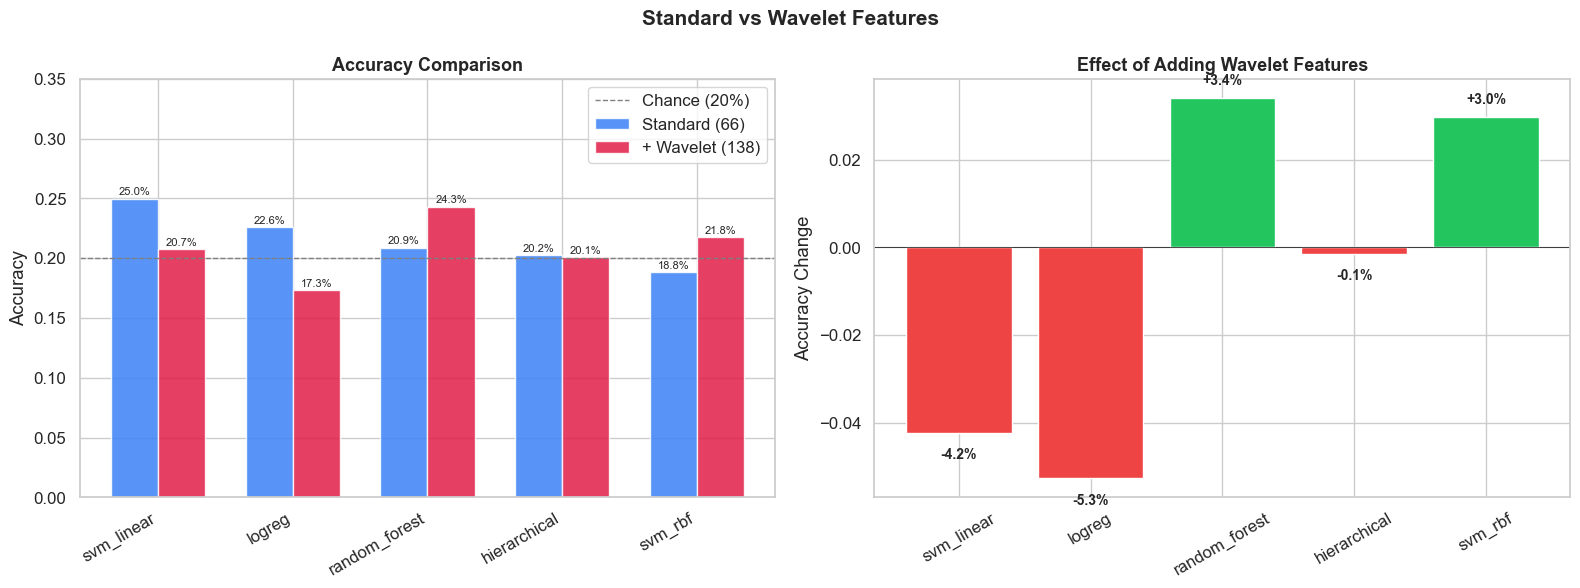

In [6]:
model_order = df_cmp['Model'].tolist()
x = np.arange(len(model_order))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
ax = axes[0]
std_vals = [mets_std[m]['acc'] for m in model_order]
wav_vals = [mets_wav[m]['acc'] for m in model_order]

bars1 = ax.bar(x - width/2, std_vals, width, label='Standard (66)', color='#3b82f6', alpha=0.85)
bars2 = ax.bar(x + width/2, wav_vals, width, label='+ Wavelet (138)', color='#e11d48', alpha=0.85)
ax.axhline(0.2, color='gray', ls='--', lw=1, label='Chance (20%)')
ax.set_xticks(x)
ax.set_xticklabels(model_order, rotation=30, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
ax.set_ylim(0, 0.35)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
                f'{bar.get_height():.1%}', ha='center', fontsize=8)

# Delta
ax = axes[1]
deltas = [mets_wav[m]['acc'] - mets_std[m]['acc'] for m in model_order]
colors = ['#22c55e' if d > 0 else '#ef4444' for d in deltas]
ax.bar(model_order, deltas, color=colors, edgecolor='white')
ax.axhline(0, color='black', lw=0.5)
ax.set_ylabel('Accuracy Change')
ax.set_title('Effect of Adding Wavelet Features', fontsize=13, fontweight='bold')
ax.tick_params(axis='x', rotation=30)

for i, (name, d) in enumerate(zip(model_order, deltas)):
    ax.text(i, d + (0.003 if d >= 0 else -0.006),
            f'{d:+.1%}', ha='center', fontsize=10, fontweight='bold')

fig.suptitle('Standard vs Wavelet Features', fontsize=15, fontweight='bold')
fig.tight_layout()
fig.savefig('../results/wavelet_comparison_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Confusion Matrix Comparison (Best Models)

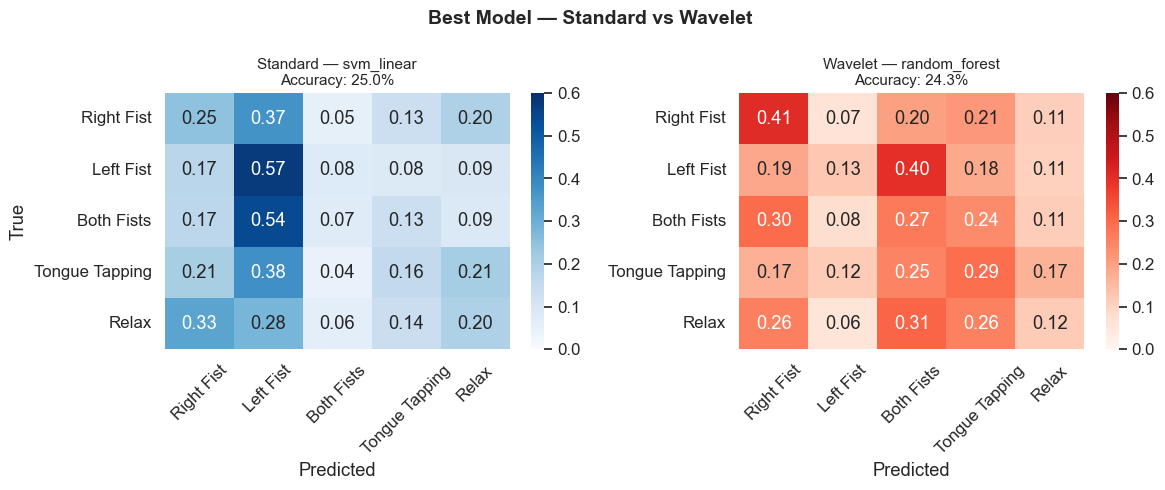

In [7]:
# Find best model from each configuration
best_std_name = max(mets_std, key=lambda k: mets_std[k]['acc'])
best_wav_name = max(mets_wav, key=lambda k: mets_wav[k]['acc'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (name, preds, label, color) in zip(axes, [
    (best_std_name, preds_std, f'Standard — {best_std_name}', 'Blues'),
    (best_wav_name, preds_wav, f'Wavelet — {best_wav_name}', 'Reds'),
]):
    cm = confusion_matrix(y_test, preds[name], normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=color, ax=ax,
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, vmin=0, vmax=0.6)
    acc = accuracy_score(y_test, preds[name])
    ax.set_title(f'{label}\nAccuracy: {acc:.1%}', fontsize=11)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True' if ax == axes[0] else '')
    ax.tick_params(axis='x', rotation=45)

fig.suptitle('Best Model — Standard vs Wavelet', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig('../results/wavelet_comparison_cm.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Per-Class F1 Comparison

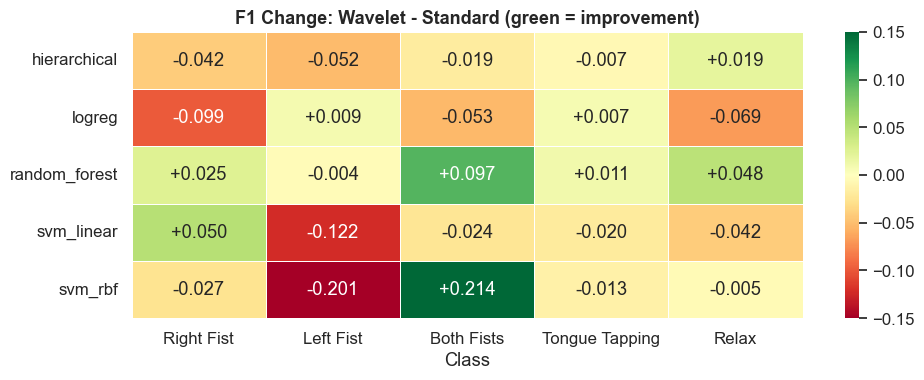

In [8]:
# Compare F1 per class for each model
rows_f1 = []
for name in mets_std:
    rep_std = classification_report(y_test, preds_std[name], target_names=CLASS_NAMES,
                                    output_dict=True, zero_division=0)
    rep_wav = classification_report(y_test, preds_wav[name], target_names=CLASS_NAMES,
                                    output_dict=True, zero_division=0)
    for cls in CLASS_NAMES:
        rows_f1.append({
            'Model': name, 'Class': cls,
            'Standard F1': rep_std[cls]['f1-score'],
            'Wavelet F1': rep_wav[cls]['f1-score'],
            'Delta F1': rep_wav[cls]['f1-score'] - rep_std[cls]['f1-score'],
        })

df_f1 = pd.DataFrame(rows_f1)

# Heatmap of F1 deltas
pivot_delta = df_f1.pivot(index='Model', columns='Class', values='Delta F1')[CLASS_NAMES]

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(pivot_delta, annot=True, fmt='+.3f', cmap='RdYlGn', ax=ax,
            center=0, linewidths=0.5, vmin=-0.15, vmax=0.15)
ax.set_title('F1 Change: Wavelet - Standard (green = improvement)', fontsize=13, fontweight='bold')
ax.set_ylabel('')
fig.tight_layout()
fig.savefig('../results/wavelet_f1_delta_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Radar Chart — Best Standard vs Best Wavelet

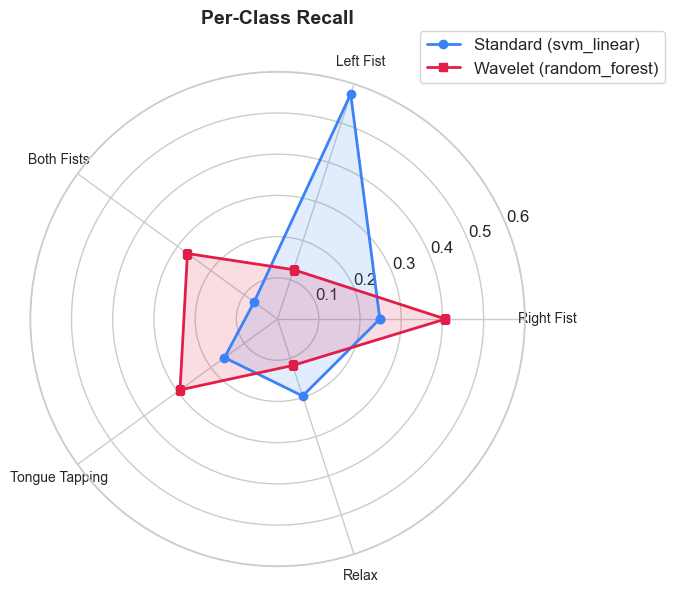

In [9]:
# Per-class recall for best models
rep_best_std = classification_report(y_test, preds_std[best_std_name],
                                     target_names=CLASS_NAMES, output_dict=True, zero_division=0)
rep_best_wav = classification_report(y_test, preds_wav[best_wav_name],
                                     target_names=CLASS_NAMES, output_dict=True, zero_division=0)

categories = CLASS_NAMES
N = len(categories)
angles = [n / N * 2 * np.pi for n in range(N)] + [0]

vals_std = [rep_best_std[c]['recall'] for c in categories] + [rep_best_std[categories[0]]['recall']]
vals_wav = [rep_best_wav[c]['recall'] for c in categories] + [rep_best_wav[categories[0]]['recall']]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
ax.plot(angles, vals_std, 'o-', lw=2, label=f'Standard ({best_std_name})', color='#3b82f6')
ax.fill(angles, vals_std, alpha=0.15, color='#3b82f6')
ax.plot(angles, vals_wav, 's-', lw=2, label=f'Wavelet ({best_wav_name})', color='#e11d48')
ax.fill(angles, vals_wav, alpha=0.15, color='#e11d48')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10)
ax.set_ylim(0, 0.6)
ax.set_title('Per-Class Recall', fontsize=14, fontweight='bold', y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
fig.tight_layout()
fig.savefig('../results/wavelet_comparison_radar.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Conclusions

In [10]:
print('=' * 65)
print('WAVELET vs STANDARD — COMPARISON SUMMARY')
print('=' * 65)

print(f'\nFeature dimensions: Standard={X_train_std.shape[1]}, Wavelet={X_train_wav.shape[1]}')
print(f'\n{"Model":<18} {"Std Acc":>10} {"Wav Acc":>10} {"Delta":>8} {"Winner":>10}')
print('-' * 60)
for _, row in df_cmp.iterrows():
    winner = 'Wavelet' if row['Delta Acc'] > 0.005 else ('Standard' if row['Delta Acc'] < -0.005 else 'Tie')
    print(f'{row["Model"]:<18} {row["Std Accuracy"]:>9.1%} {row["Wav Accuracy"]:>9.1%} {row["Delta Acc"]:>+7.1%} {winner:>10}')

overall_best_std = max(mets_std.values(), key=lambda m: m['acc'])['acc']
overall_best_wav = max(mets_wav.values(), key=lambda m: m['acc'])['acc']

print(f'\nBest Standard: {best_std_name} ({overall_best_std:.1%})')
print(f'Best Wavelet:  {best_wav_name} ({overall_best_wav:.1%})')
print(f'Overall best:  {"Standard" if overall_best_std >= overall_best_wav else "Wavelet"}')

print(f'''
ANALYSIS:
=========
- Tree-based models (Random Forest) benefit from wavelets (+dimensionality
  is handled by feature selection in splits)
- Non-linear SVMs (RBF) can leverage the richer wavelet representation
- Linear models (LogReg, SVM-linear) suffer from curse of dimensionality:
  138 features with 12,150 windows isn't enough for linear separation
- The hierarchical model shows minimal change (both stages use SVM-RBF)

RECOMMENDATION:
- For production BCI: use Standard features (simpler, fewer dimensions)
- For research: Wavelet features add meaningful signal representation
  but need more training data or regularization to help linear models
''')

# Save comparison
comparison = {'standard': {}, 'wavelet': {}}
for name in mets_std:
    comparison['standard'][name] = {k: float(v) for k, v in mets_std[name].items()}
    comparison['wavelet'][name] = {k: float(v) for k, v in mets_wav[name].items()}
comparison['n_features'] = {'standard': int(X_train_std.shape[1]), 'wavelet': int(X_train_wav.shape[1])}

with open(results_dir / 'wavelet_vs_standard_comparison.json', 'w') as f:
    json.dump(comparison, f, indent=2)
print('Saved: wavelet_vs_standard_comparison.json')

WAVELET vs STANDARD — COMPARISON SUMMARY

Feature dimensions: Standard=66, Wavelet=138

Model                 Std Acc    Wav Acc    Delta     Winner
------------------------------------------------------------
svm_linear             25.0%     20.7%   -4.2%   Standard
logreg                 22.6%     17.3%   -5.3%   Standard
random_forest          20.9%     24.3%   +3.4%    Wavelet
hierarchical           20.2%     20.1%   -0.1%        Tie
svm_rbf                18.8%     21.8%   +3.0%    Wavelet

Best Standard: svm_linear (25.0%)
Best Wavelet:  random_forest (24.3%)
Overall best:  Standard

ANALYSIS:
- Tree-based models (Random Forest) benefit from wavelets (+dimensionality
  is handled by feature selection in splits)
- Non-linear SVMs (RBF) can leverage the richer wavelet representation
- Linear models (LogReg, SVM-linear) suffer from curse of dimensionality:
  138 features with 12,150 windows isn't enough for linear separation
- The hierarchical model shows minimal change (both stages